In [265]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore, pearsonr, spearmanr

from collections import defaultdict, Counter

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from adjustText import adjust_text

from statsmodels.stats.multitest import multipletests

import re

from matplotlib.lines import Line2D

from tqdm.auto import tqdm
tqdm.pandas()

# Summary

This notebook describes how to reproduce some of the subplots shown in Figure 4, which highlights the importance and proximal causes of MDM4 exon 6 splicing.

# Load annotations

In [216]:
ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")
exonusage = pd.read_hdf("../data/CCLE_RNAseq_ExonUsageRatio_20180929.hdf",key="exonusage")

hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")
copynumber = pd.read_hdf("../data/CCLE_gene_cn.hdf",key="copynumber")

avana = pd.read_hdf("../data/Achilles_gene_effect.hdf",key="avana")
drive = pd.read_hdf("../data/D2_DRIVE_gene_dep_scores.hdf",key="drive")
achilles = pd.read_hdf("../data/D2_Achilles_gene_dep_scores.hdf",key="achilles")

Genes can be named by several ways (ENSEMBL, Entrez, HGNC, etc.). Here, we harmonize all of them by using the Biomart service. In particular, we convert the Entrez IDs used in the dependency screens to ENSEMBL ones.

In [3]:
ensembl_gene_protein = pd.read_csv("../data/ensembl_gene_protein.txt",sep="\t")
ensembl_gene_protein = ensembl_gene_protein.dropna(subset=["Protein stable ID","NCBI gene ID"])
ensembl_gene_protein["NCBI gene ID"] = ensembl_gene_protein["NCBI gene ID"].astype(int).astype(str)
ensembl_gene_protein["format_name"] = ensembl_gene_protein["HGNC symbol"] + "_" + ensembl_gene_protein["Gene stable ID"]

entrez_ensembl_map = dict(zip(ensembl_gene_protein["NCBI gene ID"],ensembl_gene_protein["format_name"]))


In [4]:
def rename_entrez_ensembl(df):
    
    df_names = pd.DataFrame(df.columns,columns=["col_name"])
    
    df_names["entrez_id"] = df_names["col_name"].str.split("_").str[-1]
    
    df_names["format_name"] = df_names["entrez_id"].apply(lambda x: entrez_ensembl_map.get(x,np.nan))
    
    df_names = df_names.dropna()
    
    df = df[list(df_names["col_name"])]
    
    df.columns = df_names["format_name"]
    
    return df
    
avana = rename_entrez_ensembl(avana)
drive = rename_entrez_ensembl(drive)
achilles = rename_entrez_ensembl(achilles)

avana = avana.loc[:,~avana.columns.duplicated(keep="first")]
drive = drive.loc[:,~drive.columns.duplicated(keep="first")]
achilles = achilles.loc[:,~achilles.columns.duplicated(keep="first")]

# Exon and gene correlations with dependency

MDM4 splicing first popped up as a notable biomarker when we ran an initial analysis looking at correlations between gene expression, exon inclusion, and dependencies. We already knew of multiple genes that exhibited a strong correlation between expression and dependency (for instance, certain cell lines became dependent on the gene due to overexpression of the gene).

Here we pull out genes in which the inclusion levels of one of the gene's exons is a better determinant of the dependency of the same gene than the bulk expression of that gene. 

In [49]:
exon_info = pd.DataFrame(exonusage.columns,columns=["exon_id"])
exon_info["ensembl_id"] = exon_info["exon_id"].str.split("_").str[-1]
exon_info["ensembl_id_stable"] = exon_info["ensembl_id"].str.split(".").str[0]
exon_info["gene_name"] = exon_info["exon_id"].apply(lambda x: re.split("_[35]p_chr",x)[0])

exon_info["stable_id"] = exon_info["gene_name"] + "_" + exon_info["ensembl_id_stable"]
exon_info["format_id"] = exon_info["gene_name"] + "_" + exon_info["ensembl_id"]

exon_info.head(5)

,exon_id,ensembl_id,ensembl_id_stable,gene_name,stable_id,format_id
0,WASH7P_3p_chr1_18379_18268_ENSG00000227232.4,ENSG00000227232.4,ENSG00000227232,WASH7P,WASH7P_ENSG00000227232,WASH7P_ENSG00000227232.4
1,WASH7P_3p_chr1_17368_17233_ENSG00000227232.4,ENSG00000227232.4,ENSG00000227232,WASH7P,WASH7P_ENSG00000227232,WASH7P_ENSG00000227232.4
2,RP11-34P13.14_3p_chr1_139847_139790_ENSG000002...,ENSG00000239906.1,ENSG00000239906,RP11-34P13.14,RP11-34P13.14_ENSG00000239906,RP11-34P13.14_ENSG00000239906.1
3,RP11-34P13.13_3p_chr1_172688_172557_ENSG000002...,ENSG00000241860.2,ENSG00000241860,RP11-34P13.13,RP11-34P13.13_ENSG00000241860,RP11-34P13.13_ENSG00000241860.2
4,RP11-34P13.13_3p_chr1_168767_168610_ENSG000002...,ENSG00000241860.2,ENSG00000241860,RP11-34P13.13,RP11-34P13.13_ENSG00000241860,RP11-34P13.13_ENSG00000241860.2


Here we define a useful helper function for calculating the Pearson/Spearman correlation coefficient between two Pandas series, which we assume to not be aligned and also to have missing values.

In [287]:
def correlate_nan(x,y,method="pearson"):
    
    assert method=="pearson" or method=="spearman", "Correlation method must be Pearson or Spearman!"
    
    x = x.dropna()
    y = y.dropna()
    x,y = x.align(y,join="inner")
    
    if len(x>=25) and len(y>=25):
        if method=="pearson":
            return pearsonr(x,y)
        elif method=="spearman":
            return spearmanr(x,y)
    
    else:
        
        return (0,1)

To compute the dependency correlates, we define a function that we may apply to the precomputed dataframe of gene and exon IDs.

In [61]:
def dependency_correlates(exon_info,dependency_set):
    dependency_ids = set(dependency_set.columns)
    gene_ids = set(ccle_genex.columns)
    
    exon_info = exon_info[exon_info["stable_id"].isin(dependency_ids)]
    exon_info = exon_info[exon_info["format_id"].isin(gene_ids)]
    
    exon_info = exon_info
    
    gene_corr = lambda row: correlate_nan(ccle_genex[row["format_id"]],dependency_set[row["stable_id"]])
    exon_corr = lambda row: correlate_nan(exonusage[row["exon_id"]],dependency_set[row["stable_id"]])
    
    gene_corrs = exon_info.progress_apply(gene_corr,axis=1)
    exon_corrs = exon_info.progress_apply(exon_corr,axis=1)
    
    exon_info["gene_r"] = [x[0] for x in gene_corrs]
    exon_info["gene_pval"] = [x[1] for x in gene_corrs]
    
    exon_info["exon_r"] = [x[0] for x in exon_corrs]
    exon_info["exon_pval"] = [x[1] for x in exon_corrs]
    
    return exon_info

avana_correlates = dependency_correlates(exon_info,avana)
drive_correlates = dependency_correlates(exon_info,drive)
achilles_correlates = dependency_correlates(exon_info,achilles)

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Because genes can have multiple exons, we only want to consider the single exon that has the highest absolute correlation with dependency.

In [101]:
avana_correlates["exon_r2"] = avana_correlates["exon_r"]**2
drive_correlates["exon_r2"] = drive_correlates["exon_r"]**2
achilles_correlates["exon_r2"] = achilles_correlates["exon_r"]**2

avana_exon_unique = avana_correlates.sort_values(
    by="exon_r2", ascending=False)
avana_exon_unique["first"] = ~avana_exon_unique["ensembl_id"].duplicated(keep="first")

drive_exon_unique = drive_correlates.sort_values(
    by="exon_r2", ascending=False)
drive_exon_unique["first"] = ~drive_exon_unique["ensembl_id"].duplicated(keep="first")

achilles_exon_unique = achilles_correlates.sort_values(
    by="exon_r2", ascending=False)
achilles_exon_unique["first"] = ~achilles_exon_unique["ensembl_id"].duplicated(keep="first")

# Plot correlations

Here we reproduce Figure 4a, or the density scatterplot with highlighted points. On the x-axis we plot the max correlation between a gene's dependency and the inclusion levels of one of its exons. On the y-axis we plot the correlation between the same gene's dependency and the bulk expression levels of said gene. We want to look for points that have a relatively high/low x-coordinate (a strong exon-dependency relationship) and a relatively small y-coordinate (a weaker expression-dependency relationship).

In [119]:
def plot_exon_gene_dependencies(x,y, significants,labels):
    
    plt.figure(figsize=(6,6))
    
    ax = plt.subplot(111)
    
    xedges, yedges = np.linspace(min(x), max(x), 128), np.linspace(min(y), max(y), 128)
    hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
    xidx = np.clip(np.digitize(x, xedges), 0, hist.shape[0]-1)
    yidx = np.clip(np.digitize(y, yedges), 0, hist.shape[1]-1)

    c = hist[xidx, yidx]
    ax.scatter(x, y, c=np.arcsinh(c), cmap="Blues", lw = 0, s=4, rasterized=True,vmin=-8)

    plt.axvline(x=0, linewidth=1, color='k',alpha=0.5,linestyle="--")
    plt.axhline(y=0, linewidth=1, color = 'k',alpha=0.5,linestyle="--")

    xlims = plt.xlim()
    ylims = plt.ylim()

    plt.xlim(xlims[0]*1.25,xlims[1]*1.25)
    plt.ylim(ylims[0],ylims[1]*1.1)

    plt.tick_params(axis=u'both', which=u'both',length=5)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if len(significants)>0:

        texts = []
    
        for x_pos, y_pos, label in zip(x[significants], y[significants],
                                       labels[significants]):
            plt.scatter(x_pos,y_pos,c="red",s=16)
            texts.append(plt.text(x_pos-0.01, y_pos-0.01, label, ha='right', va='top'))
            
        plt.xlabel("Dependency vs exon inclusion")
        plt.ylabel("Dependency vs gene expression")
        
        adjust_text(texts,autoalign='',arrowprops=dict(arrowstyle='-', color='black'))

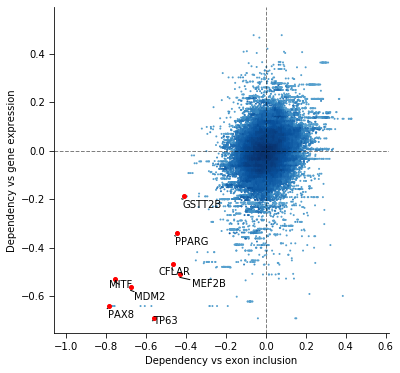

In [120]:
significants = (avana_exon_unique["exon_r"]<-0.4)&(avana_exon_unique["first"])
labels = avana_exon_unique["gene_name"]

plot_exon_gene_dependencies(avana_exon_unique["exon_r"],
                            avana_exon_unique["gene_r"],
                            significants,
                            labels
                           )

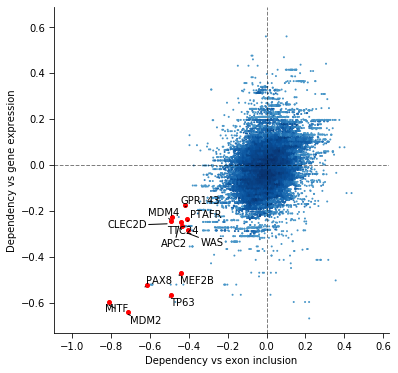

In [121]:
significants = (drive_exon_unique["exon_r"]<-0.4)&(drive_exon_unique["first"])
labels = drive_exon_unique["gene_name"]

plot_exon_gene_dependencies(drive_exon_unique["exon_r"],
                            drive_exon_unique["gene_r"],
                            significants,
                            labels
                           )

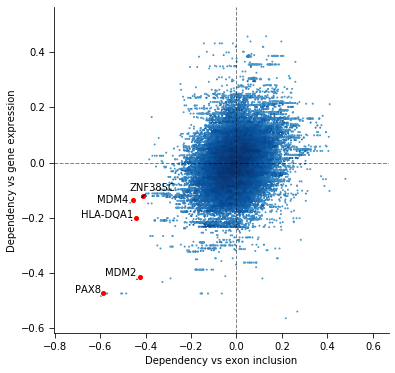

In [122]:

significants = (achilles_exon_unique["exon_r"]<-0.4)&(achilles_exon_unique["first"])
labels = achilles_exon_unique["gene_name"]

plot_exon_gene_dependencies(achilles_exon_unique["exon_r"],
                            achilles_exon_unique["gene_r"],
                            significants,
                            labels
                           )

# MDM4 sensitivity boxplot

The MDM4 protein's primary function is to inhibit the p53 tumor-suppressor, which is often inactivated in cells by mutations. We know from prior research that inclusion of exon 6 of MDM4 is necessary for this suppressive function. Therefore, we would expect cell lines in which there is both high inclusion of exon 6 and a wild-type p53 protein to be the most sensitive to MDM4, as these cell lines are depending upon MDM4 to suppress p53.

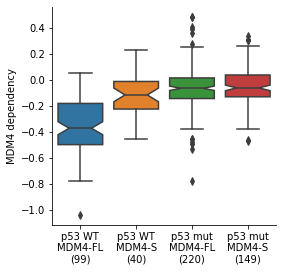

In [169]:
mdm4_merge = pd.concat([
    avana["MDM4_ENSG00000198625"].rename("MDM4_avana"),
    drive["MDM4_ENSG00000198625"].rename("MDM4_drive"),
    achilles["MDM4_ENSG00000198625"].rename("MDM4_achilles"),
    exonusage["MDM4_3p_chr1_204506558_204506625_ENSG00000198625.8"].rename("exon6_3p"),
    exonusage["MDM4_5p_chr1_204506558_204506625_ENSG00000198625.8"].rename("exon6_5p"),
    hs_muts["TP53"].rename("TP53_hs"),
    damaging_muts["TP53"].rename("TP53_damaging")
],axis=1,sort=True)

mdm4_merge["exon6_inclusion"] = (mdm4_merge["exon6_3p"] + mdm4_merge["exon6_5p"])/2

mdm4_merge = mdm4_merge.dropna(subset = ["exon6_inclusion","TP53_hs"])

mdm4_merge["exon6_included"] = mdm4_merge["exon6_inclusion"]>0.25

def mdm4_tp53_category(row):
    exon6 = row["exon6_included"]
    tp53 = row["TP53_hs"]
    
    if tp53:
        if exon6:
            return 2
        else:
            return 3
    else:
        if exon6:
            return 0
        else:
            return 1

mdm4_merge["status"] = mdm4_merge.apply(mdm4_tp53_category,axis=1)

mdm4_merge = mdm4_merge.dropna(subset=["MDM4_avana"])

plt.figure(figsize=(4,4))
ax = plt.subplot(111)  
sns.boxplot(mdm4_merge["status"],mdm4_merge["MDM4_avana"],notch=True)

counts = Counter(mdm4_merge["status"])

ax.set_xticklabels([
"p53 WT\nMDM4-FL\n("+str(counts[0])+")",
"p53 WT\nMDM4-S\n("+str(counts[1])+")",
"p53 mut\nMDM4-FL\n("+str(counts[2])+")",
"p53 mut\nMDM4-S\n("+str(counts[3])+")"])

plt.xlabel("")
plt.ylabel("MDM4 dependency")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# RPL22L1 discovery

One of the interesting discoveries that we made regarding MDM4 exon 6 inclusion was that it was not only an important marker of MDM4 sensitivity, but also that it is closely tied to the expression levels of one particular gene: RPL22L1. Here we show how RPL22L1 emerges as a top gene expression predictor of MDM4 exon 6 inclusion levels by correlating MDM4 exon 6 inclusion levels with the expression levels of every single profiled gene.

The end result is the volcano plot at the end of the section, which reproduces Figure 4f.

In [210]:
exon6_correlates = pd.DataFrame()
exon6_correlates["gene"] = ccle_genex.columns


def correlate_exon6(row):
    gene = row["gene"]

    row["r"], row["pval"] = correlate_nan(ccle_genex[gene],
                                          exonusage["MDM4_3p_chr1_204506558_204506625_ENSG00000198625.8"],
                                          method="spearman"
                                          )

    return row


exon6_correlates = exon6_correlates.progress_apply(correlate_exon6, axis=1)

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [211]:
exon6_correlates = exon6_correlates.dropna()
exon6_correlates["qval"] = multipletests(exon6_correlates["pval"],alpha=0.01,method="fdr_bh")[1]

Text(0, 0.5, '-log10(q value)')

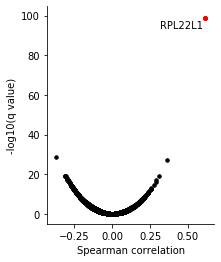

In [212]:
plt.figure(figsize=(3,4))

ax = plt.subplot(111)

x = exon6_correlates["r"]
y = -np.log10(exon6_correlates["qval"])

significants = y>50

labels = np.array(exon6_correlates["gene"].str.split("_").str[0])

ax.scatter(x,y,c="black",rasterized=True,s=12)

for x_pos,y_pos,label in zip(x[significants],y[significants],labels[significants]):
    plt.scatter(x_pos,y_pos,c="red",s=16)
    if x_pos>0:
        plt.text(x_pos-0.01, y_pos-1, label, ha='right', va='top')
    else:
        plt.text(x_pos+0.025, y_pos-1, label, ha='left', va='top')
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("Spearman correlation")
plt.ylabel("-log10(q value)")

# RPL22L1 exons

To see if MDM4 exon 6 is a particular splicing target of RPL22L1, we can correlate RPL22L1 expression levels with the inclusion levels of all profiled exons. Here we find that RPL22L1 expression is in fact most highly correlated with the inclusion levels of one of its own exons in addition to MDM4. 

The end result is a similar volcano plot that reproduces Figure 4g.

In [213]:
rpl22l1_correlates = pd.DataFrame()
rpl22l1_correlates["exon"] = exonusage.columns


def correlate_rpl22l1(row):
    exon = row["exon"]

    row["r"], row["pval"] = correlate_nan(ccle_genex["RPL22L1_ENSG00000163584.13"],
                                          exonusage[exon],
                                          method="spearman"
                                         )

    return row


rpl22l1_correlates = rpl22l1_correlates.progress_apply(
    correlate_rpl22l1, axis=1)

In [214]:
rpl22l1_correlates = rpl22l1_correlates.dropna()
rpl22l1_correlates["qval"] = multipletests(rpl22l1_correlates["pval"],alpha=0.01,method="fdr_bh")[1]

Text(0, 0.5, '-log10(q value)')

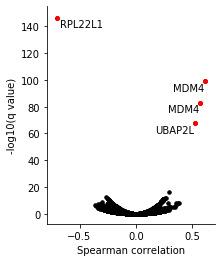

In [215]:
plt.figure(figsize=(3,4))

ax = plt.subplot(111)

x = rpl22l1_correlates["r"]
y = -np.log10(rpl22l1_correlates["qval"])

significants = y>50

labels = np.array(rpl22l1_correlates["exon"].str.split("_").str[0])

ax.scatter(x,y,c="black",rasterized=True,s=12)

for x_pos,y_pos,label in zip(x[significants],y[significants],labels[significants]):
    plt.scatter(x_pos,y_pos,c="red",s=16)
    if x_pos>0:
        plt.text(x_pos-0.01, y_pos-1, label, ha='right', va='top')
    else:
        plt.text(x_pos+0.025, y_pos-1, label, ha='left', va='top')
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("Spearman correlation")
plt.ylabel("-log10(q value)")

# RPL22L1 and RPL22

We actually know from previous research that RPL22L1 becomes overexpressed in cancer cells because its paralog, RPL22, becomes inactivated due to nonsense mutations and copy number deletions. Here we show both RPL22L1 expression and MDM4 exon 6 inclusion in the context of RPL22 mutations/copy number, which reproduces Figure 4h and 4i.

In [234]:
rpl22_merge = pd.concat([
    ccle_genex["RPL22L1_ENSG00000163584.13"].rename("RPL22L1_expression"),
    copynumber["RPL22_6146"].rename("RPL22_copynumber"),
    damaging_muts["RPL22"].rename("RPL22_damaging"),
    exonusage["MDM4_3p_chr1_204506558_204506625_ENSG00000198625.8"].rename("MDM4_exon6")
],axis=1,join="outer",sort=True)

rpl22_merge = rpl22_merge.dropna(subset=["RPL22_copynumber","RPL22_damaging"])

def rpl22_status(row):
    rpl22_copynumber = row["RPL22_copynumber"] < 0.75
    rpl22_mut = row["RPL22_damaging"]
    
    if not rpl22_copynumber and not rpl22_mut:
        return 0
    if rpl22_copynumber:
        return 1
    if rpl22_mut:
        return 2
    
rpl22_merge["status"] = rpl22_merge.apply(rpl22_status,axis=1)

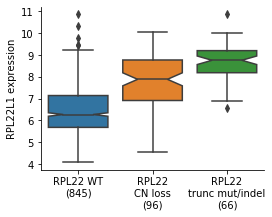

In [233]:
rpl22_rpl22l1_merge = rpl22_merge.dropna(subset=["RPL22L1_expression"])

plt.figure(figsize=(4,3))
ax = plt.subplot(111)

sns.boxplot(rpl22_rpl22l1_merge["status"],
            rpl22_rpl22l1_merge["RPL22L1_expression"],notch=True)

counts = Counter(rpl22_rpl22l1_merge["status"])

ax.set_xticklabels([
"RPL22 WT\n("+str(counts[0])+")",
"RPL22\nCN loss\n("+str(counts[1])+")",
"RPL22\ntrunc mut/indel\n("+str(counts[2])+")"])

plt.xlabel("")
plt.ylabel("RPL22L1 expression")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

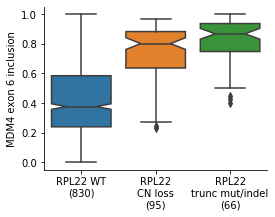

In [235]:
rpl22_mdm4_merge = rpl22_merge.dropna(subset=["MDM4_exon6"])

plt.figure(figsize=(4,3))
ax = plt.subplot(111)

sns.boxplot(rpl22_mdm4_merge["status"],
            rpl22_mdm4_merge["MDM4_exon6"],notch=True)

counts = Counter(rpl22_mdm4_merge["status"])

ax.set_xticklabels([
"RPL22 WT\n("+str(counts[0])+")",
"RPL22\nCN loss\n("+str(counts[1])+")",
"RPL22\ntrunc mut/indel\n("+str(counts[2])+")"])

plt.xlabel("")
plt.ylabel("MDM4 exon 6 inclusion")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# RPL22L1 dependency

Lastly, we confirm that overexpression of RPL22L1 induces a dependency on RPL22L1 itself. We can show this by plotting RPL22L1 expression against RPL22L1 dependency, and coloring each cell line by its p53 and RPL22 statuses.

(-1.25, 0.25)

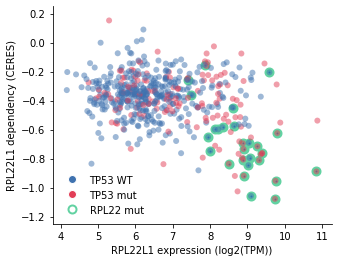

In [286]:
all_merge = pd.concat([
    ccle_genex["RPL22L1_ENSG00000163584.13"].rename("RPL22L1_expression"),
    avana["RPL22L1_200916"].rename("RPL22L1_dependency"),
    damaging_muts["RPL22"].rename("RPL22_damaging"),
    hs_muts["TP53"].rename("TP53_hs").map(lambda x: {0:"TP53 WT",1:"TP53 mut"}[x])
],axis=1,join="inner",sort=True)

plt.figure(figsize=(5,4))
ax = plt.subplot(111)

rpl22_mut = all_merge[all_merge["RPL22_damaging"]==1]

sns.scatterplot(rpl22_mut["RPL22L1_expression"],
                rpl22_mut["RPL22L1_dependency"],
                linewidth=4,
                edgecolor="#62d2a2"
               )

sns.scatterplot(all_merge["RPL22L1_expression"],
                all_merge["RPL22L1_dependency"],
                linewidth=0,
                alpha=0.5,
                hue=all_merge["TP53_hs"],
                palette = sns.color_palette(["#3f72af","#e23e57"]),
                legend=False
               )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xlabel("RPL22L1 expression (log2(TPM))")
plt.ylabel("RPL22L1 dependency (CERES)")

legend_elements = [Line2D([0], [0], marker='o', color="white",label='TP53 WT',
                          markerfacecolor='#3f72af', markersize=8),
                  Line2D([0], [0], marker='o', color="white", label='TP53 mut',
                          markerfacecolor='#e23e57', markersize=8),
                  Line2D([0], [0], marker='o', color="white", label='RPL22 mut',
                          markerfacecolor='white',markeredgecolor="#62d2a2", markeredgewidth=2,markersize=8),]

ax.legend(handles=legend_elements, loc='lower left',frameon=False)

plt.ylim(-1.25,0.25)
